In [221]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas
import geopy
from geopy import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import re

import warnings
warnings.filterwarnings('ignore')

In [141]:
# Load datasets for mental health services, SBHCs, and police outcomes
mhs = pd.read_csv('../../data_sets/cleaned_data_sets/smh_service_clean.csv')
sbhc = pd.read_csv('../../data_sets/cleaned_data_sets/list_of_nyc_schoolbhc_clean.csv')
policing = pd.read_csv('../../data_sets/cleaned_data_sets/clean_SSA_Report_School_2020.csv')
demographics = pd.read_csv('../../data_sets/cleaned_data_sets/clean_demographic_snapshot_schools.csv')

In [157]:
mhs.head()
# mhs['ATS System Code'].value_counts()
# Only one record per school

,Unnamed: 0,ATS System Code,Location Name,Primary Address,Area,Zip Code,Type of Service
0,0,01M015,P.S. 015 Roberto Clemente,333 EAST 4 STREET,MANHATTAN,10009,Community School MH
1,1,01M020,P.S. 020 Anna Silver,166 ESSEX STREET,MANHATTAN,10002,School-based Mental Health Clinic
2,2,01M034,P.S. 034 Franklin D. Roosevelt,730 EAST 12 STREET,MANHATTAN,10009,School-based Mental Health Clinic
3,3,01M063,The STAR Academy - P.S.63,121 EAST 3 STREET,MANHATTAN,10009,School-based Mental Health Clinic
4,4,01M064,P.S. 064 Robert Simon,600 EAST 6 STREET,MANHATTAN,10009,School-based Health Center w/ Mental Health


In [143]:
sbhc.head()

,Unnamed: 0,SBHC Sponsor,SBHC Campus,Address,School DBN,School Name
0,0,Bedford-Stuyvesant Family Health Center,PS 054 Samuel C Barnes,"195 Sandford Street\nBrooklyn, NY, 11205",13K054 K141@13K054,P.S. 054 Samuel C. Barnes D75 Program
1,1,Bedford-Stuyvesant Family Health Center,PS 256 Benjamin Banneker,"114 Kosciuszko Street\nBrooklyn, NY, 11216",13K256\n84K702,P.S. 256 Benjamin Banneker Community Partnersh...
2,2,Bedford-Stuyvesant Family Health Center,George E Wibecan Campus,"794 Monroe Street\nBrooklyn, NY, 11221",16K309\n84K712,P.S. 309 The George E. Wibecan Preparatory Aca...
3,3,Brooklyn Plaza Medical Center,Benjamin Banneker\nAcademy,"71 Clinton Avenue\nBrooklyn, NY, 11205",13K670,Benjamin Banneker Academy
4,4,Brownsville Multi-Service Family Health,Thomas Jefferson Campus,"400 Pennsylvania Avenue\nBrooklyn, NY, 11207",19K502\n19K504\n19K507\n19K510\n79K925@K435\n7...,FDNY - Captain Vernon A. Richard High School F...


In [144]:
policing.head()

,Unnamed: 0,School Campus,Intervention Type,Incident Location,Greater Than 21,Scanning Type,Scanning Incident,School Related,School Hours,Enforcment By,Restraints,Force,Type Of Force,Top Charge,SummonsCharge,Classification
0,0,47 THE AMERICAN SIGN LANGUAGE & ENGLISH SECOND...,Child in Crisis,On-Site,No,Non-Scanning,N,Y,Y,NaN,No Restraints,N,None,NaN,NaN,NaN
1,1,47 THE AMERICAN SIGN LANGUAGE & ENGLISH SECOND...,Child in Crisis,On-Site,No,Non-Scanning,N,Y,Y,NaN,No Restraints,N,None,NaN,NaN,NaN
2,2,47 THE AMERICAN SIGN LANGUAGE & ENGLISH SECOND...,Mitigated,On-Site,No,Non-Scanning,N,Y,Y,DOE,No Restraints,N,None,NaN,NaN,NaN
3,3,Abraham Lincoln HS(BS),Juvenile Report,On-Site,No,Full-Time,N,Y,N,PATROL,No Restraints,N,None,NaN,NaN,M
4,4,Abraham Lincoln HS(BS),Juvenile Report,On-Site,No,Full-Time,Y,Y,Y,SSA,No Restraints,N,None,NaN,NaN,M


In [145]:
demographics.head()

,DBN,School Name,Year,Total Enrollment,Grade 3K+PK (Half Day & Full Day),Grade K,Grade 1,Grade 2,Grade 3,Grade 4,...,% White,# Missing Race/Ethnicity Data,% Missing Race/Ethnicity Data,# Students with Disabilities,% Students with Disabilities,# English Language Learners,% English Language Learners,# Poverty,% Poverty,Economic Need Index
0,01M015,P.S. 015 Roberto Clemente,2016-17,178,17,28,33,27,31,24,...,2.2%,0,0.0%,51,28.7%,12,6.7%,152,85.4%,88.2%
1,01M015,P.S. 015 Roberto Clemente,2017-18,190,17,28,32,33,23,31,...,3.2%,0,0.0%,49,25.8%,8,4.2%,161,84.7%,89.0%
2,01M015,P.S. 015 Roberto Clemente,2018-19,174,13,20,33,30,30,20,...,3.4%,0,0.0%,39,22.4%,8,4.6%,147,84.5%,88.8%
3,01M015,P.S. 015 Roberto Clemente,2019-20,190,14,29,28,38,33,29,...,4.7%,0,0.0%,46,24.2%,17,8.9%,155,81.6%,86.7%
4,01M015,P.S. 015 Roberto Clemente,2020-21,193,17,29,29,27,30,32,...,5.7%,0,0.0%,43,22.3%,21,10.9%,158,81.9%,85.6%


# Do mental health services provided at schools differ according to % poverty, disability, English language learners of student body?

### We do not use the same approach to mental health services at every school. A variety of programs are implemented through the School Mental Health Program. Schools were assigned to mental health programs based on various factors such as school need, community resources, and existing mental health services. One of the following mental health programs is offered at your child’s school:

* **Community School Mental Health Program**
  * works with community mental-health providers to offer counseling, trainings, interventions, and crisis support.
* **School Mental Health Specialist Program**
  * connects schools with mental-health organizations, provides trainings, implements trauma-informed group interventions and links students and families to community resources.
* **School Mental Health Prevention and Intervention Program**
  * offers counseling, trainings, crisis support, and interventions.
* **School Response Team Programs**
  * provide crisis support and interventions, staff trainings, and mental-health referrals for families and students.
* **School-Based Mental Health Clinics (Article 31)**
  * provide individual and family treatment and crisis support in the school for students and their families.
* **School-Based Health Centers with Mental Health Services (Article 28)**
  * provide health services such as physical exams, vaccinations, and mental health services.

[source](https://www.schools.nyc.gov/school-life/health-and-wellness/mental-health)

In [349]:
# Merge mhs and demographics data
mhs_demo = mhs.merge(
    demographics,
    how='inner',
    left_on='ATS System Code',
    right_on='DBN'
)

# Subset just to 2020-21 demographics for now (the MHS data is from 2020-21)
mhs_demo_21 = mhs_demo[mhs_demo['Year'] == '2020-21']

mhs_demo_21['% Black'].head()

4     27.5%
9     13.3%
14    38.1%
19    19.2%
24    18.2%
Name: % Black, dtype: object

In [147]:
mhs_demo_21['Type of Service'].unique()

array(['Community School MH', 'School-based Mental Health Clinic',
       'School-based Health Center w/ Mental Health',
       'School Mental Health Specialist Program', 'School Response Team',
       'Prevention Intervention Program MH', 'H+H School'], dtype=object)

In [350]:
def remove_non_numbers(x):
    '''
    Function to take a string and remove any non-numeric or decimal points, in order to cast as float.
    '''
    return float(re.sub('[^\d+\.]', '', x))


def plot_percent_and_category(df, percent, category):
    '''
    Function to plot a percent variable against a categorical variable.
    
    Args: df: a pandas DataFrame
    percent: string, column name of percent column
    category: string, column name of cateogrical column
    
    Returns:
    '''
    # Set x as float of % poverty
    x = df[percent].map(remove_non_numbers)
    y = df[category].astype('category')
    
    sns.boxplot(x=x, y=y)
    
    plt.show()

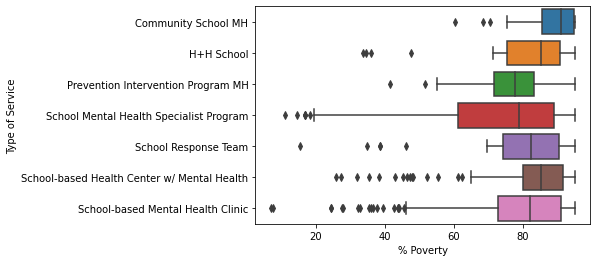

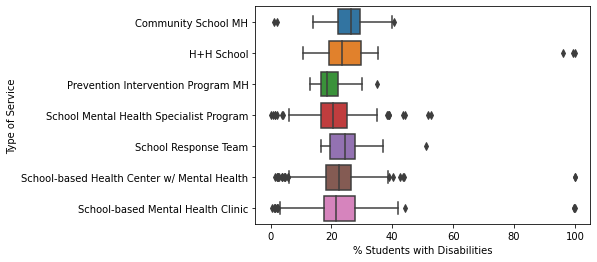

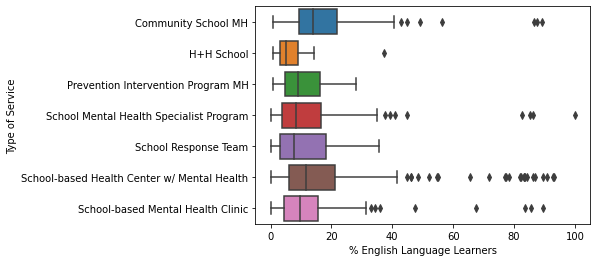

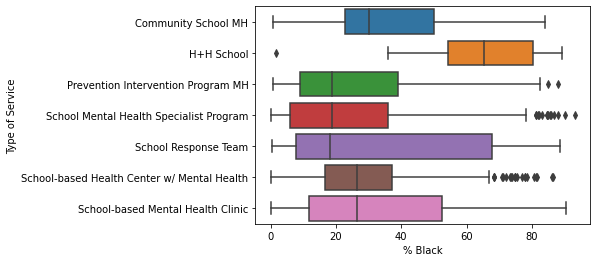

In [351]:
plot_percent_and_category(mhs_demo_21, '% Poverty', 'Type of Service')
plot_percent_and_category(mhs_demo_21, '% Students with Disabilities', 'Type of Service')
plot_percent_and_category(mhs_demo_21, '% English Language Learners', 'Type of Service')
plot_percent_and_category(mhs_demo_21, '% Black', 'Type of Service')

In [352]:
def one_way_anova(df, percent):
    
    try:
        df[percent] = df[percent].map(remove_non_numbers)
    except:
        df[percent] = df[percent]

    _, pvalue = stats.f_oneway(
        df[df['Type of Service'] == 'Community School MH'][percent],
        df[df['Type of Service'] == 'H+H School'][percent],
        df[df['Type of Service'] == 'Prevention Intervention Program MH'][percent],
        df[df['Type of Service'] == 'School Mental Health Specialist Program'][percent],
        df[df['Type of Service'] == 'School Response Team'][percent],
        df[df['Type of Service'] == 'School-based Health Center w/ Mental Health'][percent],
        df[df['Type of Service'] == 'School-based Mental Health Clinic'][percent]
    )
    
    return '{}: {}'.format(percent, pvalue)

In [353]:
one_way_anova(mhs_demo_21, '% Poverty')

'% Poverty: 2.4195759375168023e-21'

In [354]:
one_way_anova(mhs_demo_21, '% Students with Disabilities')

'% Students with Disabilities: 1.3227768105444662e-08'

In [355]:
one_way_anova(mhs_demo_21, '% English Language Learners')

'% English Language Learners: 5.239578472062176e-09'

In [356]:
one_way_anova(mhs_demo_21, '% Black')

'% Black: 1.502676468127871e-14'

In [357]:
mhs_demo_21.groupby('Type of Service')[['% Poverty', '% Students with Disabilities', '% English Language Learners', '% Black']].mean()

,% Poverty,% Students with Disabilities,% English Language Learners,% Black
Type of Service,,,,
Community School MH,88.956589,25.760465,18.119380,36.954264
H+H School,78.057692,31.296154,7.042308,64.565385
Prevention Intervention Program MH,75.862791,20.011628,10.558140,27.465116
School Mental Health Specialist Program,72.826923,20.987574,11.443195,25.982249
School Response Team,76.227586,25.158621,12.603448,33.886207
School-based Health Center w/ Mental Health,83.345896,22.364925,18.155970,29.897015
School-based Mental Health Clinic,77.554167,23.215625,12.568750,33.099479


# Do mental health services provided at schools differ according to neighborhood poverty?

Maybe will add a map figure in later with geocoded points for school location, points colored by service type, overlaid on a choropleth map based on % of neighborhood living below federal poverty level.

In [161]:
# locator = Nominatim(user_agent='myGeocoder')

# Are mental health services, or certain types of MHS, associated with fewer disciplinary actions or less frequent use of force?

In [284]:
# Have to join MHS and policing datasets by school name...
def fuzzy_match_by_school_name(df1, col1, df2, col2):
    '''
    Function to fuzzy match 2 dataframes by a string column representing school name.
    
    Args: df1, pandas DataFrame; col1: column name containing school name in df1
          df2, pandas DataFrame; col2: column name containing school name in df2
          
    Returns: pandas DataFrame, df1 and df2 merged on school name
    '''
    
    # Returns best match
    matches = df1[col1].apply(lambda x: process.extractOne(x, 
                                                           df2[col2].unique(),
                                                           processor=lambda x: re.sub('\.|0(\d+)', r'\1', x),
                                                           scorer=fuzz.token_set_ratio,
                                                           score_cutoff=90))
    
    df3 = df1.merge(
        matches, 
        how='left',
        left_index=True, 
        right_index=True
    )
    
    df3['link'] = df3.iloc[:, -1].str[0]
    
    df4 = df3.merge(
        df2,
        how='left',
        left_on='link',
        right_on=col2
    )
    
    return df4

In [285]:
matches = fuzzy_match_by_school_name(mhs_demo_21, 'Location Name', policing, 'School Campus')

In [292]:
matches['Force'].value_counts()
# Only 3 instances of use of force
matches['Restraints'].value_counts()
# 63 metal restraints, 6 velcro restraints
matches['Scanning Incident'].value_counts()
# 60 scanning incidents

N    543
Y     60
Name: Scanning Incident, dtype: int64

In [297]:
pd.crosstab(index=matches['Type of Service'], columns=matches['Restraints'])

Restraints,Metal,No Restraints,Velcro
Type of Service,,,
Community School MH,13,129,1
H+H School,4,11,0
Prevention Intervention Program MH,4,33,0
School Mental Health Specialist Program,10,144,4
School Response Team,1,12,0
School-based Health Center w/ Mental Health,26,161,0
School-based Mental Health Clinic,5,44,1


In [300]:
pg.chi2_independence(matches, x='Type of Service', y='Restraints')

(Restraints                                       Metal  No Restraints  \
 Type of Service                                                         
 Community School MH                          14.940299     126.636816   
 H+H School                                    1.567164      13.283582   
 Prevention Intervention Program MH            3.865672      32.766169   
 School Mental Health Specialist Program      16.507463     139.920398   
 School Response Team                          1.358209      11.512438   
 School-based Health Center w/ Mental Health  19.537313     165.601990   
 School-based Mental Health Clinic             5.223881      44.278607   
 
 Restraints                                     Velcro  
 Type of Service                                        
 Community School MH                          1.422886  
 H+H School                                   0.149254  
 Prevention Intervention Program MH           0.368159  
 School Mental Health Specialist Program      1

In [301]:
pg.chi2_independence(matches, x='Type of Service', y='Scanning Incident')

(Scanning Incident                                     N          Y
 Type of Service                                                   
 Community School MH                          128.771144  14.228856
 H+H School                                    13.507463   1.492537
 Prevention Intervention Program MH            33.318408   3.681592
 School Mental Health Specialist Program      142.278607  15.721393
 School Response Team                          11.706468   1.293532
 School-based Health Center w/ Mental Health  168.393035  18.606965
 School-based Mental Health Clinic             45.024876   4.975124,
 Scanning Incident                              N   Y
 Type of Service                                     
 Community School MH                          128  15
 H+H School                                    15   0
 Prevention Intervention Program MH            37   0
 School Mental Health Specialist Program      147  11
 School Response Team                          13   0
 School-b

In [314]:
plot_data = pd.crosstab(index=matches['Type of Service'], columns=matches['Scanning Incident'], margins=True)

In [323]:
plot_data['y_prop'] = plot_data['Y'] / plot_data['All'] * 100
plot_data['n_prop'] = plot_data['N'] / plot_data['All'] * 100

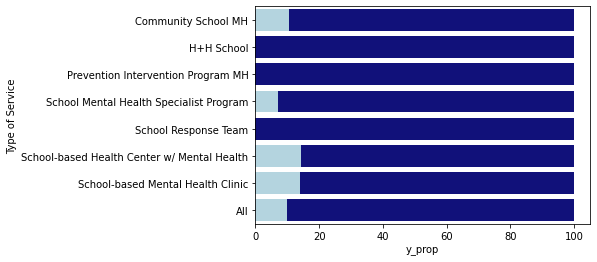

In [333]:
no_bar = sns.barplot(data=plot_data, y=plot_data.index, x=[100] * 8, color='darkblue')
yes_bar = sns.barplot(data=plot_data, y=plot_data.index, x='y_prop', color='lightblue')

In [360]:
matches.columns

Index(['Unnamed: 0_x', 'ATS System Code', 'Location Name_x', 'Primary Address',
       'Area', 'Zip Code', 'Type of Service', 'DBN', 'School Name', 'Year',
       'Total Enrollment', 'Grade 3K+PK (Half Day & Full Day)', 'Grade K',
       'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5', 'Grade 6',
       'Grade 7', 'Grade 8', 'Grade 9', 'Grade 10', 'Grade 11', 'Grade 12',
       '# Female', '% Female', '# Male', '% Male', '# Asian', '% Asian',
       '# Black', '% Black', '# Hispanic', '% Hispanic', '# Multi-Racial',
       '% Multi-Racial', '# Native American', '% Native American', '# White',
       '% White', '# Missing Race/Ethnicity Data',
       '% Missing Race/Ethnicity Data', '# Students with Disabilities',
       '% Students with Disabilities', '# English Language Learners',
       '% English Language Learners', '# Poverty', '% Poverty',
       'Economic Need Index', 'Location Name_y', 'link', 'Unnamed: 0_y',
       'School Campus', 'Intervention Type', 'Incident Location'

845